# Assigment 04: Due 9/30

You can use these imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf
from scipy import integrate
import math
%matplotlib notebook

# Problem 1a

Using Monte Carlo techniques discusses in *02_Integration_MC* notebook, solve the following integral and compare it to the exact solution:

$\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}}dx$

In your Monte Carlo integration, use 10,000 random points.

In [2]:
N= 10000
x0 = 0
x1 = 2

def f(x):
    return 2/((2**2+x**2)**(3/2))

In [3]:
x = np.linspace(x0,x1,N)
y= f(x)

fmax = max(y)
print('fmax = ',fmax)

#generate random data points
x_rand = x0 + (x1 - x0)*np.random.random(N) #between x0 and x1
y_rand = np.random.random(N)*fmax

#fill below and above arrays
ind_below = np.where(y_rand < f(x_rand))
ind_above = np.where(y_rand >= f(x_rand))

#area of the rectangel * the ratio of points below function to total points
ratio = float(len(ind_below[0])/N)
area = (x1-x0)*fmax
integral = ratio*area
exact = integrate.quad(f,0,2)
print(' ratio: {0}\n area: {1}\n integral: {2}\n exact: {3}'.format(ratio,area,integral,exact))

fmax =  0.25
 ratio: 0.6978
 area: 0.5
 integral: 0.3489
 exact: (0.3535533905932738, 3.925231146709438e-15)


# 1b

Make a scatter plot of points below and above the integrand function. This is the some type of graph shown in the *02_Integration_MC* notebook with the blue and green points.

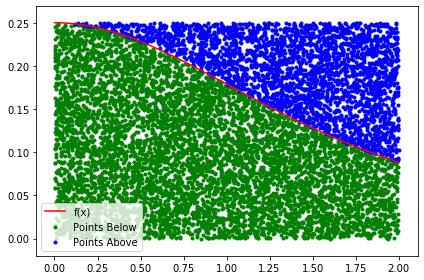

In [4]:
fig = plt.figure('MC Integration')
plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "green", marker = '.',label='Points Below')
plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "blue", marker = '.', label = 'Points Above')
plt.plot(x, y, color = "red", label= 'f(x)')
plt.legend()
plt.tight_layout();

# Problem 2a
Read in the data set *./data/decay_data.txt*, this lists the time in days, number of particles, and the uncertianty on the particles. This is the same radio active decay data set used in our fitting example *Fitting_Lecture_Notes* from Module 2b.

Plot the data with its error bars.


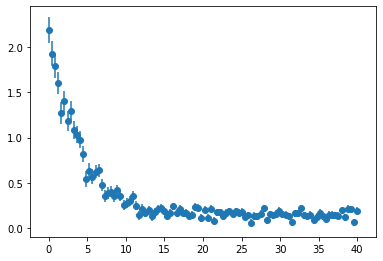

In [5]:
time, numPart, uncertainty = np.loadtxt('./data/decay_data.txt', unpack=True)
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.errorbar(time, numPart, yerr = uncertainty, fmt='.',label = 'Data')
axes.scatter(time,numPart)

# Problem 2b

Fit the data with 3 fit parameters using MCMC MH algorithm. You should take 10,000 steps and impliment the random test on $\chi ^2$, like we did our *03_MC_Fit* example notebook using the *get_chi_squared* function. For this we will use a function template of: $y = p_0 \cdot e^{-t/p_1} + p_2$,

where $p_0, p_1$, and $p_2$ are the fit parameters. When fitting you should choose starting values of $p_0 = p_1 = p_2 = 1.0$ to avoid nan errors.

In [63]:
n = 100
sigma = 1.0
p0, p1, p2 = 1.0, 1.0, 1.0

np.random.seed(0)
x = np.linspace(0,40,n)
#y = m * x + b + np.random.normal(0.0, 10.0,n) 
y = p0 * np.exp(-x/p1) + p2 + np.random.normal(0., sigma, n)

In [64]:
def f_func(t,p0,p1,p2):
    return p0 * np.exp(-t/p1) + p2

In [72]:
def get_chi_squared(x, y, sigma, params):
    '''Returns the chi squared of the fit'''
    RR = 0.0
    #print(sigma)
    for i in range(len(x)):
        y_prime = params[0] * np.exp(-x[i]/params[1]) + params[2]
        RR = RR + ( (y[i] - y_prime)/sigma[i])**2
    return RR 

In [73]:
N = 10000
init_par = np.array([1.0,1.0,1.0])
par_list, RRs = [init_par], [get_chi_squared(time, numPart, uncertainty, init_par)]
#my_list = par_list
#print(my_list)
#my_list.append([2.0,2.0])
#print(my_list[-1])

for i in range (N):
    test_par = [np.random.normal(par_list[-1][0],0.5),np.random.normal(par_list[-1][1],0.5),np.random.normal(par_list[-1][2],0.5)]
    #print(i,par_list)
    RR_test = get_chi_squared(time,numPart,uncertainty,test_par)
    #RRs.append(RR_test)
    #par_list.append(test_par)
    #print(par_list[-1])  
    t = (np.random.random() <= (RRs[-1])/RR_test )
    #print(t, RRs[-1],RRs[-1]/RR_test)
    #print(t)
    if t:
        #add new value to array
        par_list.append(test_par)
        RRs.append(RR_test)
    else:
        #add value of array
        par_list.append(par_list[-1])
        RRs.append(RRs[-1])    
            
RR_min = np.amin(RRs) #find min R2
chisq = RR_min
best_i = RRs.index(RR_min) #Get the index
best_pars = par_list[best_i]  #get the parameters  
print("best p0 = {0}, best p1 = {1}, best p2 = {2}, chi**2 = {3}, loc = {4}".format(best_pars[0], best_pars[1], best_pars[2], RR_min, best_i) )  

C:\Users\nissy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


best p0 = 1.9401787051408936, best p1 = 4.235186175775706, best p2 = 0.1313876705627926, chi**2 = 111.9702909397848, loc = 4543


# Problem 2c

What is the reduced $\chi^2$ of your fit and the p-value?
Is this a good fit?

In [77]:
#check chiq
dof = n - len(init_par) - 1
pvalue = sf.gammaincc(dof/2.0, chisq/2.0)
print('Fit Results:\n')
print(' chi2 = ',chisq,'\n dof = ', dof, '\n reduced chi2 = ', chisq/dof, '\n p-value = ',pvalue)

#The fit is decent, would prefer a p-value lower than 0.05 but the fit certainly describes the data well enough

Fit Results:

 chi2 =  111.9702909397848 
 dof =  96 
 reduced chi2 =  1.166357197289425 
 p-value =  0.12678683281385808


# Problem 2d

Plot on the same graph your data and the line showin the fitted function.

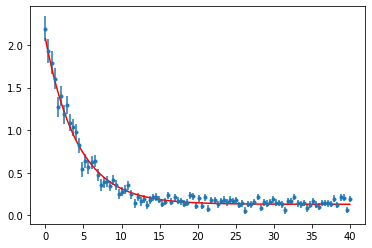

In [75]:
fig = plt.figure('Fitted Data Set')
plt.errorbar(time, numPart, yerr = uncertainty, fmt='.')
plt.plot(time,f_func(time,*best_pars),'r')

# Problem 2e

Plot the histogram distributions of the three fit parameters.

Text(0.5, 0, 'p2')

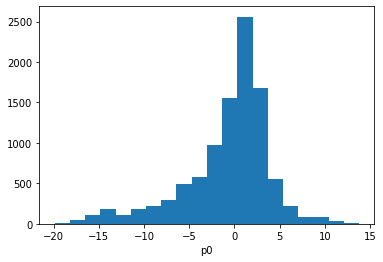

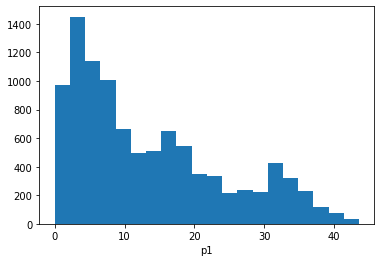

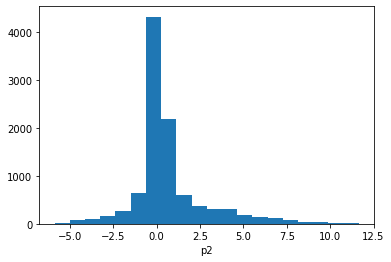

In [76]:
ps = np.array(par_list)

fig = plt.figure(2)
plt.figure(2)
plt.hist(ps[:,0], bins=20)
plt.xlabel("p0")
#plt.savefig("param_hist_m.png")

fig2=plt.figure(3)
plt.hist(ps[:,1], bins=20)
plt.xlabel("p1")
#plt.savefig("param_hist_b.png")

fig3=plt.figure(4)
plt.hist(ps[:,2], bins=20)
plt.xlabel("p2")